# Simulating NFL games with Monte Carlo

## Introduction

I want to model NFL games using teams's past performance. The idea is to take the game state (offense, defense, score, and clock) and put together a portfolio of what those teams have done in the past, then randomly choosing one of those past outcomes to move the game forward. Picture stacking rocks to build a wall. You have to choose a bunch of rocks and put them together one at a time until eventually you're left with something resembling a wall. The same principle is here. A football game is built of drives. One drive happens, then another, and another, until the teams run out of time.

## Contents

* [Introduction](#Introduction)
* [The Code](#The-code)
* [Demonstrate Monte Carlo](#Monte-Carlo-in-action)
* [Compare with ELO](#Comparing-results-with-ELO)
* [Conclusions](#Conclusions)

## The code

[Back to the top](#Contents)

As with any project, the code comes first. If you're only interested in seeing the code in action, [skip ahead to the next section](#Monte-Carlo-in-action).

In [1]:
# Load relevant packages
import pandas as pd
import numpy as np
import math
import json
from time import time
import random
from joblib import Parallel, delayed
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
datapath = "/home/welced12/git/football_analytics/data/"
# Read drive-level data from csv
alldrives = pd.read_csv(datapath+'espn_drives2009-2017.csv')

# Load game-level data from csv
gamedata = pd.read_csv(datapath+'espn_gamedata2009-2017.csv')

# Include time information on these drives
alldrives = alldrives.merge(
                right=gamedata[['gameId','season','week']],
                how='left',
                left_on='gameId',
                right_on='gameId')

In [3]:
def get_possible_drives(home,away,home_poss,time_rem,season):
    """
    Function to return past drives for an offense/defense matchup
    """

    # Set some keywords for the filter
    if home_poss:
        off_team = home
        def_team = away  
    else:
        off_team = away
        def_team = home
    
    # Filter for drives for this offense and defense
    teamdrives = alldrives.loc[
        # Condition 1: team is the offense
        ( alldrives.offense.astype(str) == off_team )
        
        | # OR
        
        # Condition 2:
        (
            (   # team is not the offense
                alldrives.offense.astype(str) != def_team
            )
            & # AND
            (   # team is either home or away
                (alldrives.home.astype(str) == def_team) |
                (alldrives.away.astype(str) == def_team)
            )
        )
    ]

    
    # Filter for drives from the past 5 seasons
    teamdrives = teamdrives.loc[ (teamdrives.season >= season-5) ]

    return teamdrives

In [4]:
# Define a class that constitutes a game
class football_game:
    """Class for representing a football game"""
    def __init__(self, home ,away, season=2018, week=1, quiet=False):

        self.home = home
        self.away = away
        self.quiet = quiet
        self.season = season
        self.week = week
        self.half = 1
        self.time_rem = 1800
        self.home_score = 0
        self.away_score = 0
        self.drive_base_weights = {}
        
        # Decide which team gets the ball to start
        coin = random.randint(1,2)
        if coin == 1:
            self.home_poss = True
        else:
            self.home_poss = False

            
    def get_drive_score(self, drive):
        
        # Weight for recency
        if self.season == drive['season']:
            # Down to 1/2 for games from this season
            w_age = 1 - (self.week - drive['week']) / 32
        else:
            # 1/2 on downward for games previous seasons
            w_age = 1 / ( 2*(self.season - drive['season']) )
        
        # Weight for home/away
        w_homeaway = 1
#        if (drive['home'] == self.home) or (drive['away'] == self.away):
#            w_homeaway = 1
        
        # Weight to favor rematch
        w_matchup = 0.75
        teams = [drive['home'],drive['away']]
        if (self.home in teams) and (self.away in teams):
            w_matchup = 1
        
        # Weight for time remaining
        w_time = 0
        if self.time_rem > 300:
            # Most of the time, time remaining won't dictate decisions.
            w_time = 1
        elif (not drive.EoH==1) or (drive.time_in_secs < self.time_rem + 10):
            numerator = drive['left_in_half'] - self.time_rem
            # Scale variance in Gaussian by time remaining.
            # More possibilities with more time left
            stdev = self.time_rem + 60 / 3
            w_time = math.exp( -(numerator)**2 / (2*stdev**2) )
              
        # Weight for score difference
        w_score = 1
        # Get scores in term's of the offense's lead
        if self.home_poss:
            curr_score_diff = self.home_score - self.away_score
        else:
            curr_score_diff = self.away_score - self.home_score
        if drive['offense'] == drive['home']:
            hist_score_diff = drive['home_score_before'] - drive['away_score_before']
        else:
            hist_score_diff = drive['away_score_before'] - drive['home_score_before']
        
        w_score = math.exp( -(curr_score_diff - hist_score_diff)**2 / 98 )
        
        # Finally, set drive fitness as a product of weights
        fitness = w_age * w_homeaway * w_matchup * w_time * w_score
        return fitness
    
    
    def get_candidate_drive(self):
        poss_drives = self.away_drives
        if self.home_poss:
            poss_drives = self.home_drives
            
        # Choose subset of drives based on time remaining in 1st/2nd half
        if self.time_rem > 300:
            poss_drives = poss_drives[ poss_drives.left_in_half >= 240 ]
        elif self.half == 1:
            poss_drives = poss_drives[
                (poss_drives.left_in_half < 360) &
                (poss_drives.secs_rem > 1800)
            ]
        else:
            poss_drives = poss_drives[
                (poss_drives.left_in_half < 360) &
                (poss_drives.secs_rem < 1800)
            ]
            
        return poss_drives.sample(1)
    
    
    def get_next_drive(self):
        """
        Returns a Series describing the next drive
        """
        # debug
        if not self.quiet:
            print("\n")
            print(self.game_sit_dict())
        
        c = 0
        accepted = False
        while not accepted:
            c += 1
            # Choose a candidate drive and score it's fitness
            candidate = self.get_candidate_drive()
            fitness_score = self.get_drive_score(candidate.loc[candidate.index[0], : ])
            # Add weight to fitness to prevent getting stuck
            if c > 100:
                fitness_score *=  1 + c/50
            
            # Choose whether to accept candidate
            r = random.random()
            if r < fitness_score:
                accepted = True
                
            # Debug printing
            if not self.quiet:
                cols = ['season', 'secs_rem', 'plays', 'time', 'result']
                print(candidate[cols])
                print(" ^ Fitness = ",fitness_score)
        
        # debug
        if not self.quiet:
            print("Evaluated", c, "candidates")
                
        return candidate.loc[ candidate.index[0], : ] # return Series
    
    
    def game_sit_dict(self):
        # Figure out which team has possession
        if self.home_poss:
            possessor = self.home
        else:
            possessor = self.away
        
        sit_dict = {'home':self.home,
                    'away':self.away,
                    'offense':possessor,
                    'half':self.half,
                    'time_rem':self.time_rem,
                    'home_score':self.home_score,
                    'away_score':self.away_score}
        return sit_dict
    
    
    def record_drive(self, drive, drive_num=1):
        """
        Given a drive, update the proper quantities, 
        assuming dataframes for chosen drives and game history have 
        already been created
        """
        # Get gamestate before this drive
        gamestate = self.game_sit_dict()
        
        # Clock changes
        gamestate_delta = {'time':drive.time_in_secs}
        if drive.time_in_secs < 10:
            gamestate_delta['time'] = 10
        
        # Score changes
        # Home team in selected drive might not be home team in sim. game
        if self.home_poss and (drive.offense == drive.home):
            flip = False
        elif self.home_poss and (drive.offense == drive.away):
            flip = True
        elif (not self.home_poss) and (drive.offense == drive.home):
            flip = True
        elif (not self.home_poss) and (drive.offense == drive.away):
            flip = False
        else:
            print("Something went wrong in determining flipped possession")
            
        if not flip:
            gamestate_delta['home_score'] = drive.home_score_after - drive.home_score_before
            gamestate_delta['away_score'] = drive.away_score_after - drive.away_score_before
        else:
            gamestate_delta['away_score'] = drive.home_score_after - drive.home_score_before
            gamestate_delta['home_score'] = drive.away_score_after - drive.away_score_before

        # Check for negative values in score delta
        scores_delta = (gamestate_delta['home_score'], gamestate_delta['away_score'])
        if sum([1 if (val < 0 or val > 8) else 0 for val in scores_delta]) > 0:
            # Recalculate score change based on drive result
            # Default to zero points
            gamestate_delta['home_score'] = 0
            gamestate_delta['away_score'] = 0
            if (drive.FG == 1):
                if self.home_poss:
                    gamestate_delta['home_score'] = 3
                else:
                    gamestate_delta['away_score'] = 3
            elif (drive.TD == 1):
                if self.home_poss:
                    gamestate_delta['home_score'] = 7
                else:
                    gamestate_delta['away_score'] = 7
                
        
        # Figure out whether possession arrow changes. Default True
        gamestate_delta['poss'] = True
        if ( (self.home_poss) & 
             (gamestate_delta['away_score'] != 0) ):
            gamestate_delta['poss'] = False
        elif ( (not self.home_poss) &
               (gamestate_delta['home_score'] != 0) ):
            gamestate_delta['poss'] = False
                    
        
        # Add entry to simulated game history
        this_series = pd.Series(gamestate)
        this_series['home_score_after'] = self.home_score + gamestate_delta['home_score']
        this_series['away_score_after'] = self.away_score + gamestate_delta['away_score']
        this_series['result'] = drive.result
        this_series['time'] = gamestate_delta['time']
        
        if drive_num == 1:  # Need to start gamestate dataFrame
            self.gamestate_df = pd.Series.to_frame(this_series)
        else:            # Add this series to gamestate dF
            series_df = pd.Series.to_frame(this_series)
            dfs = [ self.gamestate_df, series_df ]
            self.gamestate_df = pd.concat( dfs, axis=1 )
        
        # Update the game's state vars
        self.home_score += gamestate_delta['home_score']
        self.away_score += gamestate_delta['away_score']
        self.time_rem -= gamestate_delta['time']
        if gamestate_delta['poss']:
            self.home_poss = not self.home_poss

In [5]:
def simulate_game( home, away, **kwargs ):
    """
    Function to simulate one game. Returns a game object
    """
    
        # Need new wrapper for simulating a game
    if not 'season' in kwargs:
        kwargs['season'] = 2018
    if not 'week' in kwargs:
        kwargs['week'] = 1
    if not 'quiet' in kwargs:
        kwargs['quiet'] = False
        
    newgame = football_game( home, away, **kwargs )
    
    # Assign possible drives for this game
    newgame.home_drives = get_possible_drives( home, away, 
                                               True, 1800, 
                                               newgame.season )
    newgame.away_drives = get_possible_drives( home, away, 
                                               False, 1800, 
                                               newgame.season)
    
    # Choose the first drive
    first_drive = newgame.get_next_drive()
    
    # Make DataFrame for drive history, and update the game object
    newgame.drives_selected = pd.Series.to_frame(first_drive)
    drive_num = 1
    newgame.record_drive( first_drive, drive_num )
    
    for half in (1,2):
        newgame.half = half
        if half > 1:
            newgame.time_rem = 1800
            
        end_of_half = False
        while (not end_of_half) and (newgame.time_rem > 0):
            drive_num += 1
            
            # Select a new drive
            this_drive = newgame.get_next_drive()
            newgame.drives_selected = pd.concat( [newgame.drives_selected,
                                                  this_drive], axis=1 )
            
            # Update the game state
            newgame.record_drive( this_drive, drive_num )
            
            # Check for end of Half
            if this_drive.EoH == 1:
                end_of_half = True
    
    # Remove historic drives from the object to save disk space
    del newgame.home_drives
    del newgame.away_drives
        
    # Post-game, need to transpose the DataFrames
    newgame.drives_selected = newgame.drives_selected.transpose()
    newgame.gamestate_df = newgame.gamestate_df.transpose()
    if newgame.home_score > newgame.away_score:
        newgame.winner = newgame.home
    elif newgame.away_score > newgame.home_score:
        newgame.winner = newgame.away
    else:
        newgame.winner = "OT"
            
    newgame.result = {'home':newgame.home, 
                      'home_score':newgame.home_score, 
                      'away':newgame.away, 
                      'away_score':newgame.away_score,
                      'winner':newgame.winner}
    
    return newgame

In [6]:
# Wrapper for single game
def sim_one_game(home, away, silent=False, **kwargs):
    if silent:  # Make sure output will be quiet
        kwargs['quiet'] = True
        
    game_obj = simulate_game(home, away, **kwargs)
    
    if not silent:
        print(game_obj.result)
    return game_obj

# Parallelized function to sim many games in one command
def sim_many_games(home, away, iterations=25, **kwargs):
    t = time()
    
    game_objects = Parallel(n_jobs=3) \
                           (delayed(sim_one_game) \
                            (home, away, **kwargs) \
                            for i in range(iterations) )
            
    # Make dataFrame from results, so that we can do things with them
    stats = {}
    sim_results = pd.DataFrame([g.result for g in game_objects])
    wins = sim_results.groupby(['winner'])['home'].agg('count')
    win_pcts = wins/float(iterations)
    
    # Write values to dictionary that will be returned as result of function
    stats['iterations'] = iterations
    stats['home_wins'] = wins[home] if home in wins.index.values else 0
    stats['away_wins'] = wins[away] if away in wins.index.values else 0
    stats['home_winpct'] = round(win_pcts[home],3) if home in wins.index.values else 0
    stats['away_winpct'] = round(win_pcts[away],3) if away in wins.index.values else 0
    stats['home_score_avg'] = round(sim_results.home_score.mean(),1)
    stats['away_score_avg'] = round(sim_results.away_score.mean(),1)
    stats['game_objects'] = sim_results
    
    print("Simulated",iterations,"games in",time()-t,"seconds")
    
    return stats

In [7]:
# Plot to show score distributions for both teams
def score_dist_plot(game_dict):
    objects = game_dict['game_objects']
    for tm in ['home', 'away']:
        sns.distplot(objects[tm+"_score"].values,
                     bins=25,
                     hist_kws={"alpha":0.25},
                     kde_kws={"label":game_dict['game_objects'][tm].values[0]})

    # Place each team's average score on the plot
    home_avg = game_dict['home_score_avg']
    away_avg = game_dict['away_score_avg']
    plt.axvline(home_avg, linestyle='--', alpha=1, color='steelblue')
    plt.axvline(away_avg, linestyle='--', alpha=1, color='darkorange')

    # Set things with axes
    max_score = game_dict['game_objects'][['home_score','away_score']].max().values.max()
    plt.xlim( 0, max_score )
    plt.xlabel("Score")
    plt.tick_params(labelleft='off')
    plt.show()

In [8]:
# Plot showing win percentages
def win_dist_plot(game_results):
    df = game_results['game_objects']
    win_totals = df.groupby('winner').agg('count')['away']
    home = df.loc[0,'home']
    away = df.loc[0,'away']
    home_winpct = win_totals[home]/game_results['iterations']
    away_winpct = win_totals[away]/game_results['iterations']
    ot_pct = win_totals['OT']/game_results['iterations']
    
    # set up figure, draw lines
    xmin = 0
    xmax = 1
    y = 0.5
    height = 0.175
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    plt.hlines(y,xmin,xmax)
#    plt.vlines(xmin, y-height/2., y+height/2)
#    plt.vlines(xmax, y-height/2., y+height/2)
    
    # Make numberline
    for p in [0.25, 0.5, 0.75]:
        gridline = plt.Line2D( (p, p), (y-height/15, y+height/15),
                               lw=1.5, ls='-', color='black', alpha=1 )
        plt.gca().add_line(gridline)
        
    # Make rectangle objects
    home_wp = plt.Rectangle((0,y-height/2),
                             home_winpct, height,
                             alpha=0.5, fc='steelblue')
    ot = plt.Rectangle((home_winpct, y-height/2),
                       ot_pct, height, alpha=0.5, fc='gray')
    away_wp = plt.Rectangle((home_winpct+ot_pct, y-height/2),
                            away_winpct, height, alpha=0.5, fc='darkorange')
    
    # Add rectangle objects to current axis
    plt.gca().add_patch(home_wp)
    plt.gca().add_patch(away_wp)
    plt.gca().add_patch(ot)
    
    # Add annotations for team names
    ax.text(0, 0.325, home, size=22, ha='center' )
    ax.text(1, 0.325, away, size=22, ha='center')
    midpt = (home_winpct+(1-away_winpct))/2
    ax.text(midpt, 0.325, str(round(midpt*100,1))+"%", size=22, ha='center')
    plt.vlines(midpt, y-(height/1.7), y+(height/1.7),
               linestyle='--', color='black')

    plt.axis('off')
    plt.axis('scaled')
    plt.show()

In [9]:
# Make a plot to show win ratio convergence
def convergence_plot(results):
    hometeam = results['game_objects'].loc[0,'home']
    x = []
    wp = []
    pts = [int((i+1)*results['iterations']/100) for i in range(100)]
    for i in pts:
        subset = results['game_objects'].head(i)
        home_winpct = subset.groupby('winner').agg('count').loc[hometeam,'away']/i
        x.append(i)
        wp.append(home_winpct)
        
    ax = plt.scatter(x, wp)
    plt.gca().set_ylim(wp[-1]-0.125,wp[-1]+0.125)
    plt.gca().set_xlim(x[0],x[-1])
    plt.gca().set_xlabel("Iterations")
    plt.gca().set_ylabel(hometeam+" win rate")
    plt.axhline(0.5, linestyle='--', color='black')
    plt.axhline(wp[-1], linestyle='--', color='gray')

    plt.show()

## Monte Carlo in action

[Back to the top](#Contents)

I'll show what putting all these pieces together does in practice by simulating a hypothetical game between Pittsburgh and Baltimore. Let's say that the two teams are playing in Pittsburgh.

In [10]:
# Set seed for repeatability
np.random.seed(4224)
# Simulate a single game
game = sim_one_game("PIT", "BAL", silent=True)
game.result

{'away': 'BAL',
 'away_score': 32,
 'home': 'PIT',
 'home_score': 44,
 'winner': 'PIT'}

Pittsburgh won the simulated game 44-32. That's fun, but the power of Monte Carlo simulation comes from repeated simulations so that we can build up a body of possible outcomes and see which appear most likely to happen.

In [11]:
np.random.seed(42)
# Simulate a set of games
games = sim_many_games("PIT", "BAL", iterations=100, silent=True)

Simulated 100 games in 42.18036913871765 seconds


I simulated the same game 100 times. How did that go?

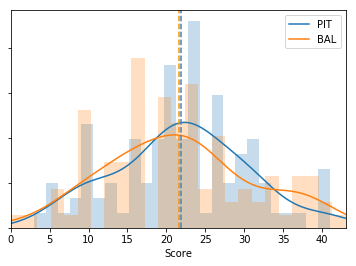

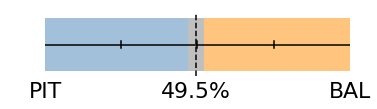

In [12]:
# Show some results
score_dist_plot(games)
win_dist_plot(games)

Monte Carlo is based on using random numbers to generate new results. If I repeat that simulation with a different seed for the random number generator, I might get something a bit different.

In [13]:
np.random.seed(1235789)
games2 = sim_many_games("PIT", "BAL", iterations=100, silent=True)

Simulated 100 games in 47.023483991622925 seconds


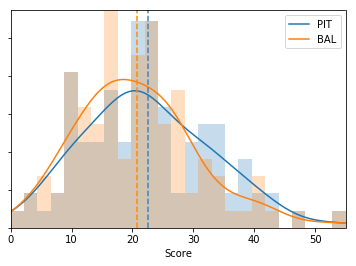

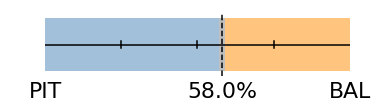

In [14]:
score_dist_plot(games2)
win_dist_plot(games2)

One of the biggest problems with using Monte Carlo based methods is figuring out when you've simulated enough results. How long does the win ratio take to converge to a single value? To figure that out, start by simulating a ton of the same game.

Simulated 7500 games in 2707.1771507263184 seconds


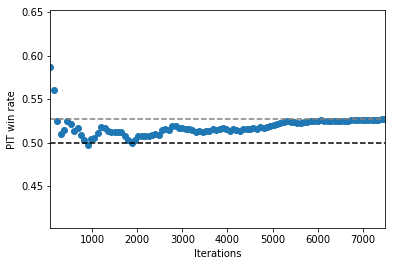

In [15]:
np.random.seed(1234)
games_conv = sim_many_games("PIT", "BAL", iterations=7500, silent=True)
convergence_plot(games_conv)

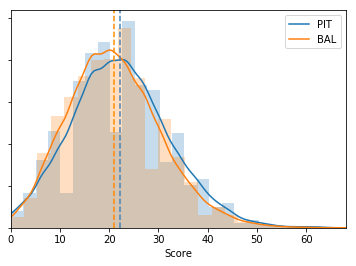

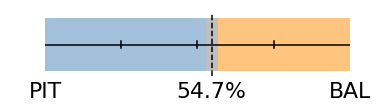

In [16]:
score_dist_plot(games_conv)
win_dist_plot(games_conv)

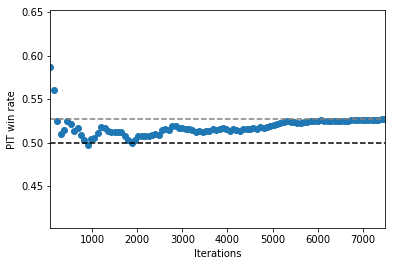

In [17]:
convergence_plot(games_conv)

This plot is showing how the win rate changes over the course of the simulation. After around 1,000 iterations, the win ratio seemed to settle between 52 and 53 percent (not including games that go to OT), and then didn't change a great deal for the rest of the simulation. It's important to keep in mind that this is just one example, so simulations of other games may not converge as quickly, but even allowing for that, I feel comfortable that results won't change significantly after 2,000 iterations.  At an approximate rate of 2.5 iterations per second, that would mean a 2,000 iteration simulation would take between 13 and 14 minutes.

## Comparing results with ELO

[Back to the top](#Contents)

So the Monte Carlo simulations do eventually converge to give an idea of how likely each team is to win a game. But, how good is that estimate? To validate the model, I will compare against the ELO ratings system. ELO ratings work by giving each team a strength rating at any given point in time. By comparing strength ratings, we can estimate the likelihood of each team winning the game. I've taken my particular formula for ELO from [fivethirtyeight](https://fivethirtyeight.com/features/introducing-nfl-elo-ratings/).

In [18]:
# Function defining how to estimate win probability from ELO ratings
def win_prob(home_elo, away_elo):
    exponent = (home_elo + 65 - away_elo)/400
    home_prob = 1 / ( 10**( -1 * exponent ) + 1 )
    away_prob = 1 / ( 10**(  1 * exponent ) + 1 )
    return (home_prob, away_prob)

# Pull historical ELO values from file
elo_file = "/home/welced12/git/football_analytics/data/elo_history.json"
with open(elo_file, 'r') as f:
    elo_hist = pd.read_json(json.load(f))

Try looking at a week 16 matchup from 2017: Carolina vs. Tampa Bay

In [19]:
# Get ELO for teams and estimate win probability
elo = elo_hist.loc['[2017,16]',:]
win_prob( elo['CAR'], elo['TB'] )

(0.647674131303877, 0.352325868696123)

Simulated 1000 games in 257.18060398101807 seconds


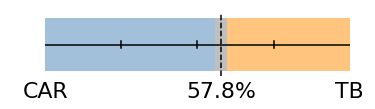

In [20]:
np.random.seed(1)
games3 = sim_many_games("CAR", "TB", 
                        season=2017, week=16,
                        iterations=1000, silent=True)
win_dist_plot(games3)

In [21]:
print(games3['home_winpct'])
(games3['home_winpct'] + (1-games3['away_winpct']))/2

0.558


0.5775

I want to look at how the model's output compares with an ELO model in terms of predicting real, historical data. To prevent biasing the model, I've included parameters to make sure that the available pool of drives that the model can choose from must come from before the simulated game was played. So if I want to simulate a game from week 3 in 2015, the model will only choose drives from week 2 of that season and earlier.

To validate the model, I would ideally test the model on a large random sample. However, because of the computation time involved (~13 minutes per game), I'll start with a sample of 25 games from 2012 onward and calculate the accuracy and Brier score (which is equivalent to the mean squared error in the case of a binary classifier) for both models.

In [22]:
games_file = "/home/welced12/git/football_analytics/data/espn_gamedata2009-2017.csv"
game_hist = pd.read_csv(games_file)

In [25]:
np.random.seed(348523)
# Get sample set of games
sample = game_hist[ game_hist.season >= 2012 ].sample(25)

for num in sample.index:
    
    # Get prediction from ELO
    row = sample.loc[num]
    elo = elo_hist.loc['['+str(row['season'])+','+str(row['week'])+']',:]
    elo_pred = win_prob( elo[row['home']], elo[row['away']] )
    sample.loc[num,'home_wp_elo'] = round(elo_pred[0],3)
    
    # Get prediction from MC
    mc_games = sim_many_games(row['home'], row['away'], 
                              season=row['season'], week=row['week'],
                              iterations=2000, silent=True)
    mc_wp = (mc_games['home_winpct'] + (1-mc_games['away_winpct']))/2
    sample.loc[num,'home_wp_mc'] = round(mc_wp,3)
    
sample

Simulated 2000 games in 917.7832849025726 seconds
Simulated 2000 games in 2178.617534160614 seconds
Simulated 2000 games in 597.7937927246094 seconds
Simulated 2000 games in 569.8899989128113 seconds
Simulated 2000 games in 581.6141498088837 seconds
Simulated 2000 games in 901.534101486206 seconds
Simulated 2000 games in 847.7691373825073 seconds
Simulated 2000 games in 544.4758641719818 seconds
Simulated 2000 games in 868.382039308548 seconds
Simulated 2000 games in 634.4496395587921 seconds
Simulated 2000 games in 935.633064031601 seconds
Simulated 2000 games in 508.9205207824707 seconds
Simulated 2000 games in 884.9171130657196 seconds
Simulated 2000 games in 630.6244184970856 seconds
Simulated 2000 games in 800.0994834899902 seconds
Simulated 2000 games in 1068.3165159225464 seconds
Simulated 2000 games in 569.4662528038025 seconds
Simulated 2000 games in 505.07715821266174 seconds
Simulated 2000 games in 772.3256649971008 seconds
Simulated 2000 games in 530.2611539363861 seconds
S

,gameId,result,season,week,home,away,winner,home_score,away_score,OT,home_wp_elo,home_wp_mc
1004,321223007,"DEN 34, CLE 12",2012,16,CLE,DEN,DEN,12,34,0,0.257,0.387
891,321104011,"IND 23, MIA 20",2012,9,MIA,IND,IND,20,23,0,0.737,0.485
1638,400791540,"OAK 37, SD 29",2015,7,OAK,SD,OAK,37,29,0,0.445,0.426
2079,400951679,"ATL 34, GB 23",2017,2,GB,ATL,ATL,23,34,0,0.586,0.462
2165,400951729,"SEA 41, HOU 38",2017,8,HOU,SEA,SEA,38,41,0,0.421,0.394
947,321202008,"IND 35, DET 33",2012,13,IND,DET,IND,35,33,0,0.586,0.562
897,321104019,"PIT 24, NYG 20",2012,9,PIT,NYG,PIT,24,20,0,0.588,0.524
2142,400951575,"BUF 30, TB 27",2017,7,TB,BUF,BUF,27,30,0,0.604,0.460
1148,331103020,"NYJ 26, NO 20",2013,9,NO,NYJ,NYJ,20,26,0,0.850,0.588
1969,400874684,"GB 27, PHI 13",2016,12,GB,PHI,GB,27,13,0,0.466,0.583


In [26]:
# Calculate model accuracy
for num in sample.index:
    row = sample.loc[num]
    home_win = 1 if row['home_score'] > row['away_score'] else 0
    sample.loc[num,'home_win'] = home_win

# Make list of when predictions were correct
corr_elo = [1 if abs(f-o) < 0.5 else 0 
            for (f, o) in zip(sample.home_wp_elo.values, sample.home_win.values)]
corr_mc  = [1 if abs(f-o) < 0.5 else 0 
            for (f, o) in zip(sample.home_wp_mc.values, sample.home_win.values)]
# Get Brier score for each prediction, same as mean squared error here
brier_elo = [(f-o)**2
             for (f, o) in zip(sample.home_wp_elo.values, sample.home_win.values)]
brier_mc  = [(f-o)**2
             for (f, o) in zip(sample.home_wp_mc.values, sample.home_win.values)]

summary = {
    'acc_elo'  : sum(corr_elo)/len(corr_elo),
    'acc_mc'   : sum(corr_mc)/len(corr_elo),
    'score_elo': round(sum(brier_elo)/len(brier_elo),4),
    'score_mc' : round(sum(brier_mc)/len(brier_mc),4)
}

summary

{'acc_elo': 0.56, 'acc_mc': 0.64, 'score_elo': 0.2866, 'score_mc': 0.2397}

I've calculated the accuracy of both my Monte Carlo model and the simpler ELO model on the sample set, as well as the [Brier score](https://en.wikipedia.org/wiki/Brier_score) for both models. The higher the accuracy, the more often the model correctly predicted the outcome of a game. The Brier score is basically a cost function that punishes overconfidence from a model; a lower Brier score means that the model's confidence is better-calibrated to match reality.

This particular set of 25 games flatters the Monte Carlo model, which correctly predicted the winner in 64% of the games in the sample set compared with 58% from the ELO model. The Monte Carlo model also scored a lower Brier score, significantly outperforming the ELO model on this sample set.

## Conclusions

[Back to the top](#Contents)

This is a fairly small sample set that could contain a disproportionate number of upsets or other outliers, and it's hard to draw any sweeping conclusions about either model from these results. It could be statistical noise, but the initial results show that my Monte Carlo model appears to be better than a coin flip, and at least competitive with the ELO model. Further testing is definitely warranted.